In [1]:
#general definitions and imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import logging
logging.Logger.disabled=True

import os
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import numpy as np
import matplotlib.pyplot as plt

import ipytest
ipytest.autoconfig()
from pytest import approx

from pathlib import Path

from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Probe.Plot import plot
from PySpice.Math import *

import schemdraw
import schemdraw.elements as elm
from schemdraw import dsp
from schemdraw import logic

from IPython.display import display, HTML

## setup spice library path
directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)
## set the project directory as directory_path
directory_path = Path(os.path.abspath('')).resolve()

In [2]:
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    __R = 100@u_kΩ

    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__R__ = R
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )
        
    def wiper(self, w) :
        if w == 0 :
            self.R1.resistance = self.__R * 0.0000001
            self.R2.resistance = self.__R * 0.9999999
        elif w == 1 :
            self.R1.resistance = self.__R * 0.9999999
            self.R2.resistance = self.__R * 0.0000001
        else :
            self.R1.resistance = self.__R * w
            self.R2.resistance = self.__R * (1.0-w)

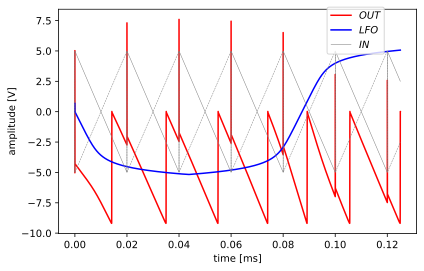

In [3]:
kicad_netlist_path = directory_path.joinpath('main', 'Animator1_2.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

circuit = parser.build_circuit(ground=5)
circuit.include(spice_library['TL072c'])
circuit.include(spice_library['D1N4148'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'IN', circuit.gnd, 'DC 5 Pulse(-5 5 0 0 20m 0.00001m 20.001m)')
circuit.V('4', 'INV_IN', circuit.gnd, 'DC 5 Pulse(5 -5 0 0 20m 0.00001m 20.001m)')

#for c in ( VoltageDivider(R=1@u_MΩ, w=0.5, name='POT_1')) :
circuit.subcircuit(VoltageDivider(R=1@u_MΩ, w=0.98, name='POT_1'))

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
#simulator.options('INTERP')
simulator.initial_condition(LFO1=0.0)
analysis = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=125@u_ms)
#analysis_dc = simulator.operating_point()
    
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(analysis['OUT'].abscissa, analysis['OUT'], color='Red')
ax1_buffer.plot(analysis['LFO1'].abscissa, analysis['LFO1'], color='Blue')
ax1_buffer.plot(analysis['IN'].abscissa, analysis['IN'], color='Grey', linewidth=0.5)
ax1_buffer.plot(analysis['INV_IN'].abscissa, analysis['INV_IN'], color='Grey', linewidth=0.5, linestyle='dashed')

ax1_buffer.legend(('$OUT$', '$LFO$', '$IN$'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()

# construction



# calibration

there is no calibration needed. but the potentiomenter knobs have to be aliged to center position.


# usage

the input jacks are wired to 5 volts when nothing is connected.

all channels are mixed to the out jack. when something is connected to the channel out, this channel is removed from the overall mix.

_mixer_
* connect the different channels from audio or cv sources to the in jacks.
* connect the out jack to something
* turn the pots clockwise to adjust the volume.

_attenuverter_
* connect all or a single channel. 
* when you turn the pot knob counter clockwise the signal is inverted.


